In [76]:
"""Code to compute the unbiased mutual information landscapes from a set of mutual information landscapes from
   systematic subsamples of the flow cytometry/micrscopy data.
   
Author: Swarnavo Sarkar
Email: swarnavo.sarkar@nist.gov
"""

import os
import sys

import pandas as pd
import numpy as np
import scipy.optimize as optim
import math
import scipy.special as sp
from scipy.stats import beta
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [77]:
def linear_fit(x,a,b):
    return a*x+b

In [78]:
data_directory = '/Volumes/Shared_Data/GSF-IMS/E-Coli/pLMSF-lacI/2020-02-25_IPTG-Cytom-12-plasmids/CpVER-IPTG-048'
os.chdir(data_directory)

# Filename for the family of landscapes 
casename = 'trial'

# upper and lower limits for the input random variable
ub, lb = 6.0,-3.0

# Enter axes label strings
y_name = r"$\sigma$"
x_name = r"$E$"

# Enter tick locations
x_ticks = [1,10,100,1000]
y_ticks = [10,100,1000]

# scale either 'log' or 'linear'
scale = 'log'

data_fractions = [1,2,5,10]
n_samples = list(range(1,6))

In [79]:
dataframes = []
xlist = []

data_size = 0

for df in data_fractions:
    df_str = str(df)

    for n in n_samples:
        xlist.append(float(df))
        filename = 'MI_landscape-'+casename+df_str+'_'+str(n)+'.csv'
        dataframes.append(pd.read_csv(filename))
        data_size += 1

x = np.array(xlist)

In [80]:
dataframes[-1].rename(columns={'Unnamed: 0': ''},inplace=True)

data_shape = dataframes[-1].shape
index_set = dataframes[-1].index
columns_set = list(dataframes[-1].columns)
rows_set = list(dataframes[-1][columns_set[0]])

column_range = range(0,len(columns_set))

output_frame = dataframes[-1].copy()
output_pcov = dataframes[-1].copy()

In [81]:
max_MI = 0
MI_var = 0
max_coord = [0,0]

for i in index_set[1:]:
    for jj in column_range[1:]:
        y = []

        for k in range(0,data_size):
            j = dataframes[k].columns[jj]
            y.append(dataframes[k].at[i,j])

        popt, pcov = optim.curve_fit(linear_fit,x,np.array(y))

        if popt[1]>max_MI:
            max_MI = popt[1]
            max_coord = [float(rows_set[i]),float(j)]
            MI_var = pcov[1,1]

        j = output_frame.columns[jj]
        output_frame.at[i,j] = popt[1]

In [82]:
#output_frame.T.to_csv('LimitingMI_surface.csv',header=False)
output_frame.to_csv('LimitingMI_surface.csv',index=False)

f = open('C-coord.txt','w')
print('C = ',max_MI,file=f)
print('C_var = ',MI_var,file=f)
print('Mean = ',max_coord[0],file=f)
print('Std = ',max_coord[1],file=f)

In [83]:
m, s = math.log10(max_coord[1]), math.log10(max_coord[0])
print(m,s)

s_m = (m-lb)/(ub-lb)
s_v = (s**2)/((ub-lb)**2)

p = s_m*(s_m*(1-s_m)/s_v - 1)
q = (s_m*(1-s_m)/s_v - 1) - p

xx = np.linspace(lb,ub,1000)

xpdf = beta.pdf(xx,p,q,lb,(ub-lb))

xcdf = beta.cdf(xx,p,q,lb,(ub-lb))

solution = np.zeros(shape=(1000,3))

solution[:,1] = xpdf
solution[:,2] = xcdf
solution[:,0] = 10**xx

np.savetxt('p_c.csv',solution,delimiter=',')

2.36734693877551 1.3571428571428572


In [84]:
f = open('C-coord.txt','w')
print('C = ',max_MI,file=f)
print('C_var = ',MI_var,file=f)
print('Mean = ',max_coord[1],file=f)
print('Std = ',max_coord[0],file=f)
f.close()

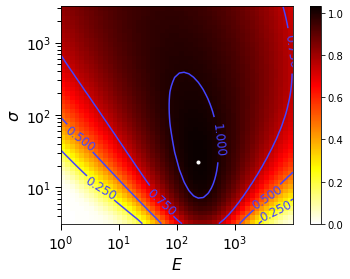

In [86]:
# plot landscape
out_mat = output_frame.to_numpy()
MI_matrix = out_mat[:,1:]

std_range = out_mat[:,0]

mean_l = []

for l in list(output_frame)[1:]:
    mean_l.append(float(l))

mean_range = np.array(mean_l)

# Set up for contour
X = np.zeros(MI_matrix.shape)
Y = np.zeros(MI_matrix.shape)

for i in range(0,int(len(list(mean_range)))):
    for j in range(0,int(len(list(std_range)))):
        X[i,j] = mean_range[j]
        Y[i,j] = std_range[i]

MImax = np.max(MI_matrix)
MImin = np.min(MI_matrix)

levels = list(np.linspace(0,2,9))

fig = plt.figure()
plt.axes().set_aspect(1.25)

hot_reversed = plt.cm.get_cmap('hot_r')

C = plt.pcolor(mean_range,std_range,MI_matrix,cmap=hot_reversed,vmin=0.0,vmax=MImax)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
#plt.title(plot_title,fontsize=14)

if scale=='log':
    plt.xscale('log')
    plt.yscale('log')

plt.yticks(y_ticks)
plt.xticks(x_ticks)

plt.tick_params(axis='x',which='major',length=6, width=1)
plt.tick_params(axis='x',which='minor',length=4, width=1)

plt.tick_params(axis='y',which='major',length=6, width=1)
plt.tick_params(axis='y',which='minor',length=4, width=1)

plt.ylabel(y_name,fontsize=16)
plt.xlabel(x_name,fontsize=16)

cs = plt.contour(X,Y,MI_matrix,np.array(levels),colors='#4444FF')
plt.clabel(cs,fontsize='large')

plt.plot(max_coord[1],max_coord[0],color='white',marker='o',markersize=3)

#plt.plot(max_coord[1],max_coord[0],color='white',marker='.',markersize=10)

#MI_text = str("%.2f"%round(max_MI,2))+'('+str("%.1f"%round(max_coord[1],1))+','+str("%.2f"%round(max_coord[0],2))+')'
#plt.text(0.5*max_coord[1],1.1*max_coord[0],MI_text,fontsize=14,color='white')

#plt.xscale('log')
cbar = fig.colorbar(C)

cbar.ax.tick_params(labelsize=10)

#cbar_fit = ax.imshow(MI_matrix,cm)

#fig.tight_layout()

#plt.show()

fig.savefig('Limit_landscape.pdf', bbox_inches='tight')
fig.savefig('Limit_landscape.png', bbox_inches='tight', dpi=300)